In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
os.listdir()

['all_data_comparisons.ipynb',
 '.DS_Store',
 'figs',
 'prediction_analyses.ipynb',
 'grid_search_results.csv',
 'grid_search_analysis.ipynb',
 'grid_search.ipynb',
 'n_features_info.csv',
 'models',
 '__pycache__',
 'README.md',
 'example.ipynb',
 '.ipynb_checkpoints',
 'starting_code',
 'example_all.ipynb',
 'data',
 'flu_matrix_completion.py']

In [25]:
# Contains a list of grid analysis entries and their corresponding RMSEs
# The grid analysis done on the matrix completion model tested permutations of the hyperparameters available in the mode
# such as feature number, number of total trees to train, and the number of best trees to use for prediction
grid_search_df = pd.read_csv("grid_search_results.csv").set_index("full_comparison_name").drop(["Unnamed: 0"], axis=1)
# n_features_info_df contains information on the number of overlapping viruses between each comparison (source and target table pair tested in grid analysis) 
n_features_info_df = pd.read_csv('n_features_info.csv').set_index('Unnamed: 0')
comparisons = []
for i in n_features_info:
    _, source, _, target, _, _, _, _, _ = i.split(' ') # Extract relevant information (source and target table names from entry)
    comparison_name = f"{source[:-1]}_to_{target[:-1]}" # Create a name for the comparison which can be used for identifying subsets of grid_search_df
    comparisons.append(comparison_name)
# grid_per_comparison is a dict containing all the grid search entries corresponding to a comparison (entries will be permutations of hyperparameter settings)
grid_per_comparison = {comparison: [i for i in grid_search_df.index if comparison in i] for comparison in comparisons}

# The following code creates a dataframe that can be used to plot the grid analysis for each comparison
grid_heatmap_per_comparison = dict()
for comparison in comparisons:
    grid_indices = grid_per_comparison[comparison]
    grid_heatmap_df = pd.DataFrame() # Heatmap of grid analysis results for a comparison (source and target table pair)
    for idx in grid_indices: # Iterate over each entry name from the grid search dataframe
        if "fon" in idx or "hin" in idx:
            source, _, target_p1, target_p2, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') 
            
        else:
            source, _, target, _, _, n_features, _, _, train_trees, _, _, best_trees = idx.split('_') # Extract relevant fields from entry name
        RMSE = grid_search_df.loc[idx, 'RMSE'] # Access the recorded RMSE of the grid analysis entry
        grid_heatmap_df.loc[f'n_features_{n_features}',f'train_trees_{train_trees}_best_trees_{best_trees}'] = RMSE # Save the grid search information to a dataframe that can be plotted as a heatmap
    grid_heatmap_per_comparison[comparison] = grid_heatmap_df
    

<Axes: >

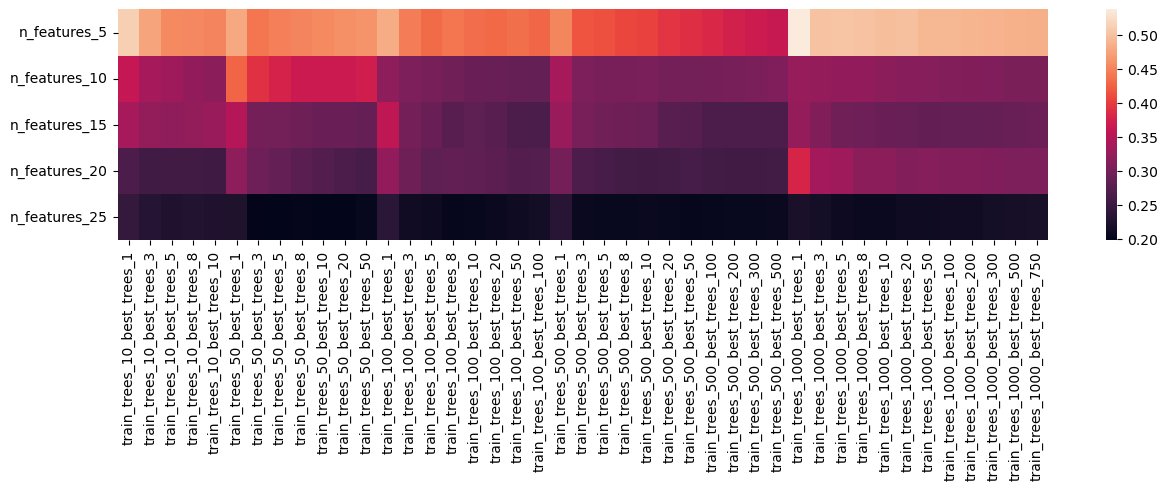

In [33]:
plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS5'])

<Axes: >

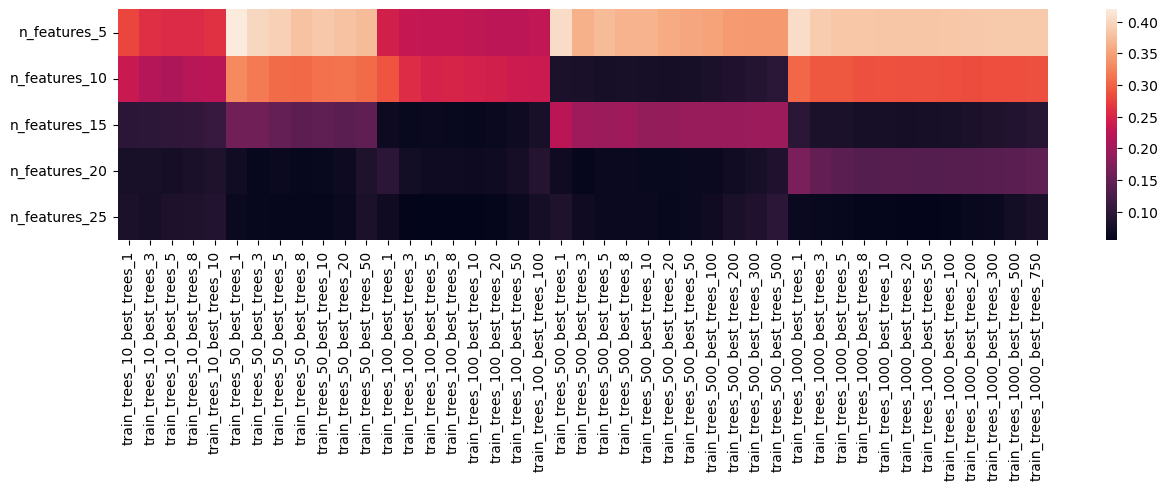

In [36]:
plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS1'])

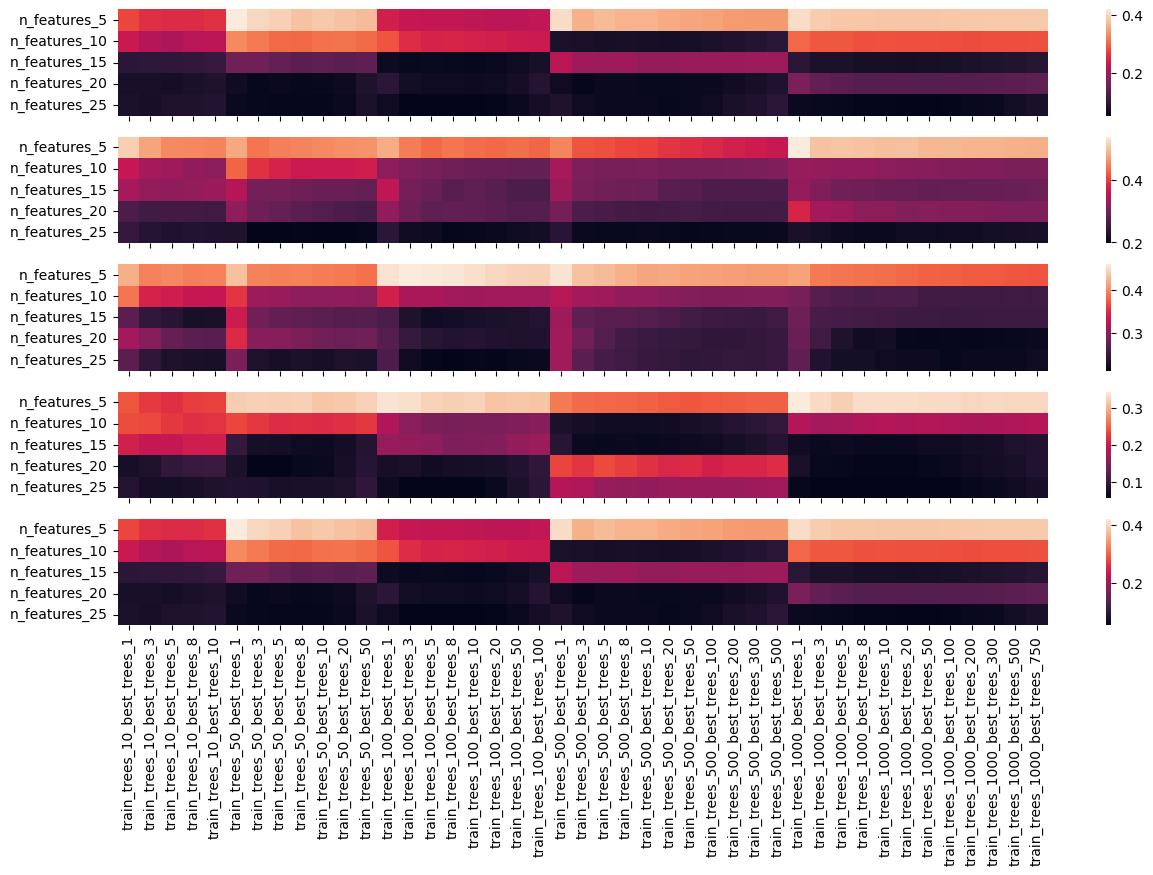

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

In [56]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15,8))

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS1'], ax=axs[0])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS5'], ax=axs[1])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS6'], ax=axs[2])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS13'], ax=axs[3])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS14'], ax=axs[4])

axs[0].set_xticklabels("")
axs[1].set_xticklabels("")
axs[2].set_xticklabels("")
axs[3].set_xticklabels("")

plt.show()

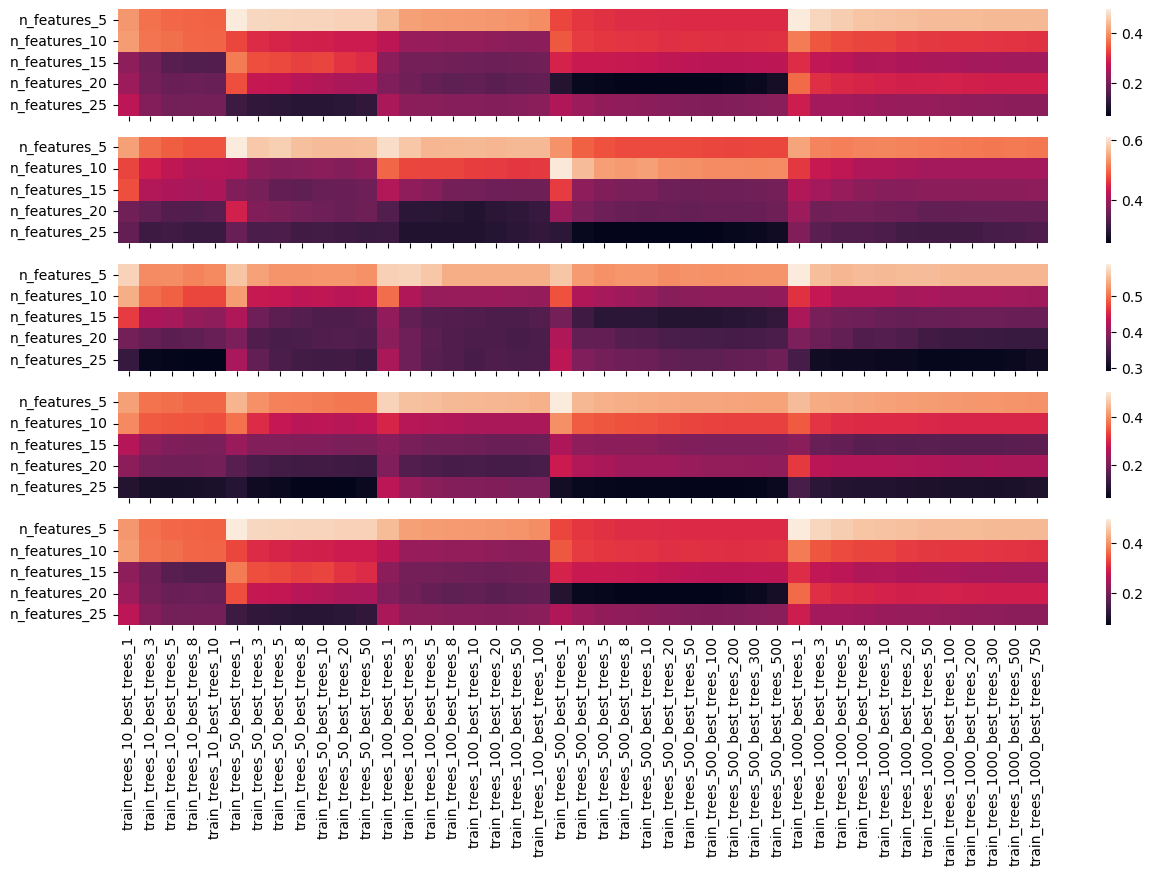

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

<Figure size 1500x300 with 0 Axes>

In [57]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15,8))

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS1'], ax=axs[0])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS5'], ax=axs[1])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS6'], ax=axs[2])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS13'], ax=axs[3])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.1_to_TableS14'], ax=axs[4])

axs[0].set_xticklabels("")
axs[1].set_xticklabels("")
axs[2].set_xticklabels("")
axs[3].set_xticklabels("")

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15,8))

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_fon_children ax=axs[0])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_fon_ferrets'], ax=axs[1])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_hin_vu14vi15'], ax=axs[2])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_hin_vu15vi16'], ax=axs[3])

plt.figure(figsize=(15, 3))
sns.heatmap(grid_heatmap_per_comparison['TableS3.2_to_TableS14'], ax=axs[4])

axs[0].set_xticklabels("")
axs[1].set_xticklabels("")
axs[2].set_xticklabels("")
axs[3].set_xticklabels("")

plt.show()

In [38]:
grid_heatmap_per_comparison.keys()

dict_keys(['TableS3.2_to_TableS1', 'TableS3.2_to_TableS5', 'TableS3.2_to_TableS6', 'TableS3.2_to_TableS13', 'TableS3.2_to_TableS14', 'TableS3.2_to_fon_children', 'TableS3.2_to_fon_ferrets', 'TableS3.2_to_hin_vu14vi15', 'TableS3.2_to_hin_vu15vi16', 'TableS3.2_to_hin_u15u16', 'TableS3.1_to_TableS1', 'TableS3.1_to_TableS5', 'TableS3.1_to_TableS6', 'TableS3.1_to_TableS13', 'TableS3.1_to_TableS14', 'TableS3.1_to_fon_children', 'TableS3.1_to_fon_ferrets', 'TableS3.1_to_hin_vu14vi15', 'TableS3.1_to_hin_vu15vi16', 'TableS3.1_to_hin_u15u16'])